# Predictive coding in a network

Here, we derive and simulate dynamical equations for an N-dimensional network of neurons based on the derivations from the single neuron [1].

## Vectorizing the differential equations

Vectorizing the readout differential equation leads to

\begin{align}
    \dot{y}(t) = - y(t) + \textbf{D}^T\textbf{o}(t),  
\end{align}

where changes in $y(t)$ depend on the scalar product of a row vector $\textbf{D}^T = \frac{1}{N}(D_1, D_2, ..., D_N)$ and column vector $\textbf{o}(t)$ describing each neuron's spike train.

In [756]:
import numpy as np
import numpy.random as rand
import matplotlib.pyplot as plt
from numpy import linalg as LA
#from cmaps import nice_cmap
from matplotlib.legend_handler import HandlerLine2D
import math
%matplotlib inline

" Parameters/containers "
VERBOSE = False                     # Printout
N       = 3                         # Number of neurons

T       = 20                        # Total duration
dt      = 0.001                     # Integration time step
time    = np.arange(0, T, dt)       # Time array
V       = np.zeros((N,len(time)))   # Membrane voltage
a       = 1.                        # Input amplitude
x       = np.zeros(len(time))       # Constant input
stlen   = int((T/dt)/5)             # Duration of stimulus (20% of T = 4)
stm0    = int((T/dt)/2)             # Number of time steps for stimulus begin
stm1    = stm0+stlen                # Number of time steps for stimulus end (stm1-stm0==stmlen)
x[stm0:stm1] = a                    # Offset
#x       += a*np.abs(np.cumsum(rand.normal(0.0,0.02,len(time))))
#x       += a*rand.normal(0.0,0.1,len(time)) ## Adding white noise
x       = np.abs(x) 
y       = np.zeros(len(time))       # Decoder
o       = np.zeros((N,len(time)))   # Spikes
st      = []                        # Spike times + index
rate    = np.zeros((N,len(time)))   # Firing rate
mu      = 0.00001                   # Regularization constant
D       = 0.1*np.ones(N)/N          # Random readout weights (normally distributed)
inh     = int(0.92*N)
D[inh:] = -1. * D[inh:]
#D       = 0.1*rand.normal(.0, 1., N)/N
W       = np.outer(D,D) + mu*np.eye(N)
if VERBOSE:
    evals, evecs = LA.eigh(W)
    print("Recurrent weights:", W)
    print("Readout weights:", D)
    print("Spectral radius:", evals)
Thr     = np.dot(D,D)/2 + mu/2      # Threshold
decay   = 1.                        # Decay constant
if VERBOSE:
    print("Threshold:", Thr)    

" Voltage ODE "
def dV(i, spike):
    return - V[:,i] + D*(x[i]+(x[i+1]-x[i])/dt) - W.dot(spike)/dt

" Decoder ODE "
def dy(i, spike):
    return - y[i] + D.dot(spike)/dt
" Rate ODE "
def dr(i, spike):
    return - rate[:,i] + spike/dt

" List difference function "
def diff(a):
    return [a[i+1]-a[i] for i in range(len(a)-1)]

" Randomly choose one spike "
def rand_one(array):
    return rand.choice(np.ravel(np.nonzero(array)), 1)[0]

" Update step "
def step(i):
    if np.sum(o[:,i] > 0):
        st.append(t)
    " Potential (Euler) "
    V[:,i+1] = V[:,i] + dt * dV(i, o[:,i])   
    " Check spikes "    
    o[:,i+1] = (V[:,i+1] > Thr)
    if np.sum(o[:,i+1])>0:
        specfl = rand_one(o[:,i+1])
        o[:, i+1] = np.eye(N)[specfl]
    " Decoder (Euler) "
    y[i+1] = y[i] + dt * dy(i, o[:,i+1])
    " Estimate firing rate (Euler) "
    rate[:,i+1] = rate[:,i] + dt * dr(i, o[:,i+1])
    
" Simulation "
for i,t in enumerate(time[:-1]):
    if math.fmod(t,2)==0:
        print("t:",t)
    step(i)
    if np.sum(o[:,i])>0 and VERBOSE:
        print("Spike time:", t, "@neuron", np.argmax(o[:,i])+1, np.sum(o[:,i]))
print("Spikes/time:", np.sum(o)/(N*T/2))
print("Mean inverse ISI:", 1./(N*np.mean(diff(st))))


t: 0.0
t: 2.0
t: 4.0
t: 6.0
t: 8.0
t: 10.0
t: 12.0
t: 14.0
t: 16.0
t: 18.0
Spikes/time: 5.7
Mean inverse ISI: 14.0751780096


In [760]:
" Plotting "
def plot_fig1():
    npanels = 4
    f, axarr = plt.subplots(npanels, sharex=True)
    K=3
    drawN = N
    lcols = int(math.ceil(drawN/3))
    Rsize = K*drawN+1
    excV = plt.get_cmap('Reds', int(0.8*Rsize))
    inhV = plt.get_cmap('Blues', int(0.2*Rsize))
    excR = plt.get_cmap('autumn', int(0.8*Rsize))
    inhR = plt.get_cmap('winter', int(0.2*Rsize))
    f.set_figheight(npanels*2)
    f.set_figwidth(npanels*3)
    plt.xticks(np.arange(0,25,1))

    " Panel A: Decoding signal"
    axarr[0].plot(time, x, 'k-', label = 'Signal $x(t)$')
    axarr[0].plot(time, y, color='#cc1111', label='Decoder $y(t)$')
    axarr[0].set_ylabel("Signal")
    #axarr[0].set_ylim([-0.1, a+0.1])
    axarr[0].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

    " Panel B: Membrane potentials "
    for neuron in range(drawN):
        name = '$V_{'+str(neuron+1)+'}$'
        if neuron < inh:
            axarr[1].plot(time, V[neuron,:], color=excV(K*neuron), label = name)
        else:
            axarr[1].plot(time, V[neuron,:], color=inhV(Rsize-K*neuron), label = name)
    axarr[1].set_ylabel("Membrane potential")
    axarr[1].plot([0,T],[Thr,Thr], color='#bbbbbb')
    #axarr[1].legend(bbox_to_anchor=(1.05, 1), loc=2, ncol=lcols, borderaxespad=0.)

    " Panel C: Spike raster plot "
    for neuron in range(N):
        name = 'Neuron '+str(neuron+1)
        posy = (1+neuron)*o[neuron, o[neuron,:]==1]
        axarr[2].vlines(time[o[neuron,:]==1], posy-0.5, posy+0.5, label = name)
        #axarr[2].legend(handler_map={spikes: HandlerLine2D(numpoints=1)})
    #axarr[2].legend(bbox_to_anchor=(1.05, 1), loc=2, ncol=lcols, borderaxespad=0.)
    axarr[2].set_ylim([0, N+1])
    axarr[2].set_ylabel("Neuron index")
    spacer = int(N/10)
    if spacer==0:
        spacer = 1
    axarr[2].set_yticks(np.arange(spacer,N+1,spacer))

    " Panel D: Firing rate estimates "
    for neuron in range(drawN):
        name = '$r_{'+str(neuron+1)+'}$'
        if neuron < inh:
            axarr[3].plot(time, rate[neuron,:], color=excR(K*neuron+10), label = name)
        else:
            axarr[3].plot(time, rate[neuron,:], color=inhR(K*neuron+10), label = name)
    axarr[3].set_ylabel("Firing rate")
    #axarr[3].legend(bbox_to_anchor=(1.05, 1), loc=2, ncol=lcols, borderaxespad=0.)
    #axarr[3].set_ylim([-1, 25.000])
    plt.xlabel("Time")
    
    return f, axarr

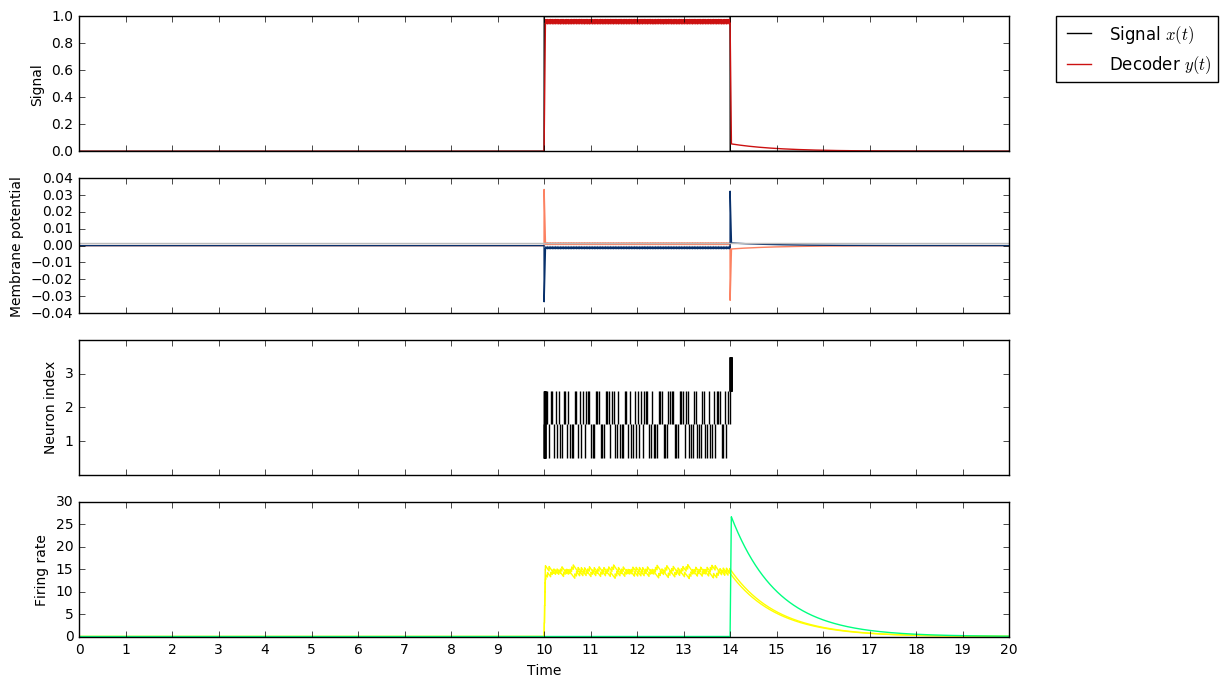

In [761]:
f, ax = plot_fig1()
plt.show()


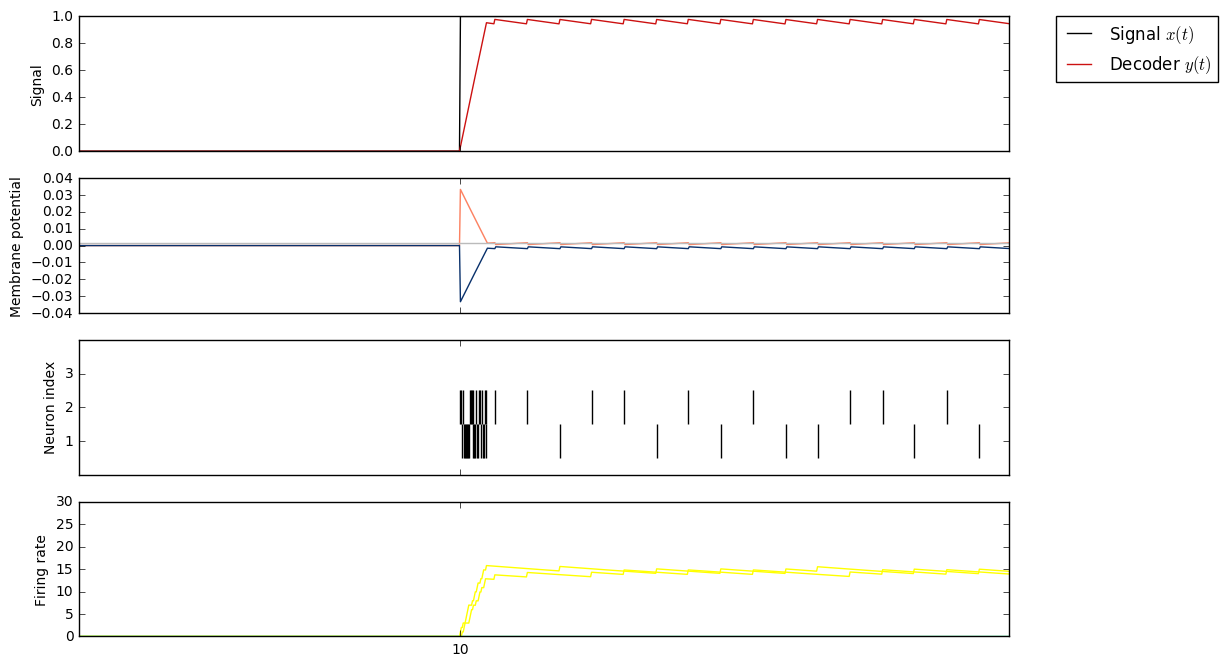

In [762]:
f, ax = plot_fig1()
plt.xlim([9.59, 10.59])
plt.show()


In [245]:
means = []
rates = []
mus = []
" Goes through different values for D "
for trials in range(5):
    mu = 10 ** (trials-5) # -5, -4, -3, -2, -1
    mus.append(mu)
    V        = np.zeros((N,len(time)))    # Membrane potential
    y        = np.zeros(len(time))        # Decoder
    o        = np.zeros((N,len(time)))    # Spikes
    rate     = np.zeros((N,len(time)))    # Firing rate
    st = []
    for i,t in enumerate(time[:-1]):
        step(i)
    means.append(np.mean((x-y)**2))
    rates.append(np.mean(rate[:,hns:], axis=1)) # based on ISI
    print(mu, np.mean(rates[-1]), np.std(rates[-1]))
    #print("D: %1.2f\tInverse Mean ISI:%1.9f (%u samples)" % (D, 1./np.mean(diff(st)), len(st)))
minmu = mus[np.argmin(means)]
print("Minimum error:", np.min(means), "at Gamma", minmu)


1e-05 18.1447555395 0.0636062388415
0.0001 15.5065785467 0.0283847351414
0.001 6.50838924449 0.0275234819221
0.01 1.2985728033 0.00867460725716
0.1 0.402363270769 0.00534043606124
Minimum error: 0.00560981956666 at Gamma 1e-05


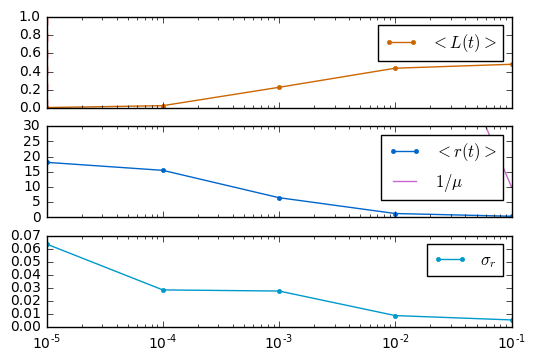

In [343]:
" Print/plot minimum error w.r.t. D "
f, axarr = plt.subplots(3, sharex=True)
axarr[0].semilogx(mus, means, '.-', color='#cc6600', label = '$<L(t)>$')
axarr[0].semilogx([minmu, minmu], [0.0, 1.0], 'r--')
axarr[0].legend()

axarr[1].semilogx(mus, np.mean(rates, axis=1), '.-', color='#0066cc', label = '$<r(t)>$')
axarr[1].semilogx(mus, a/np.asarray(mus), color='#cc66cc', label = '$1/\mu$')
axarr[1].set_ylim((0.0,30.0))
axarr[1].legend()

axarr[2].semilogx(mus, np.std(rates, axis=1), '.-', color='#0099cc', label = '$\sigma_r$')
axarr[2].legend()
plt.show()


In [617]:
test = np.array([0.05, -0.05])
print(test)

[ 0.05 -0.05]


In [618]:
testM = np.outer(test,test)
print(testM)

[[ 0.0025 -0.0025]
 [-0.0025  0.0025]]
